# Xpedia 

Our goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event. Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together.

### MVP1:
 - Try different classification models
 - Feature engineering
  * PCA
  * combine columns
  * selection - investigate correlation with target variable
  * search attributes
 - Scaling
 - Remove outliers
 - Train on bookings
 - Train on bookings + clicks
 - Evaluate on selected metric (MAP5)
 
### MVP2:
Add extra features
 - User history
 - User event cluster
 - Destination cluster

### MVP3:
 - Recommender
 - Investigate how to use a recommender system for this problem
  * collaborative filtering (on user or item level)
  * hybrid model combining use clicks/booking data & search features


https://www.kaggle.com/c/expedia-hotel-recommendations/data

In [210]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load data

In [ ]:
data_dir = './expedia-hotel-recommendations/'

destinations = pd.read_csv(data_dir + 'destinations.csv')
train = pd.read_csv(data_dir + 'train.csv')
train_bookings = train[train['is_booking'] == 1]
test = pd.read_csv(data_dir + 'test.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [13]:
train_sample = train.sample(500000)
train_sample.to_csv(data_dir + './train_sample.csv', index=False)

## Destinations

Consists of features extracted from hotel reviews text

* d1-d149: latent description of search regions	
* srch_destination_id: ID of the destination where the hotel search was performed

In [5]:
destinations.shape

(62106, 150)

In [4]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


## Train

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

<AxesSubplot:>

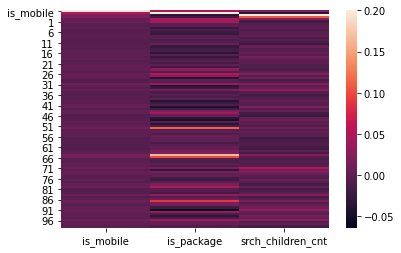

In [197]:
sns.heatmap(
(train_sample[['is_mobile', 'is_package', 'srch_children_cnt', 'srch_adults_cnt']]
        .join(pd.get_dummies(train_sample['hotel_cluster']))
        .corr()[['is_mobile', 'is_package', 'srch_children_cnt']]), vmax=0.2
           )

In [8]:
train.shape

(37670293, 24)

In [7]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [36]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,24145292.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,...,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000,37670293.00000
mean,9.79527,2.68047,86.10880,308.40601,27753.04473,1970.09003,604451.75318,0.13493,0.24890,5.87076,...,0.33212,1.11266,14441.09054,2.58228,0.07966,1.48338,3.15630,81.29685,600.46188,49.80861
std,11.96754,0.74804,59.24310,208.44375,16782.55320,2232.44243,350617.46204,0.34165,0.43238,3.71709,...,0.73150,0.45912,11066.30233,2.15302,0.27076,1.21978,1.62319,56.17119,511.73913,28.91595
min,2.00000,0.00000,0.00000,0.00000,0.00000,0.00560,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
25%,2.00000,3.00000,66.00000,174.00000,13009.00000,313.16700,298910.00000,0.00000,0.00000,2.00000,...,0.00000,1.00000,8267.00000,1.00000,0.00000,1.00000,2.00000,50.00000,160.00000,25.00000
50%,2.00000,3.00000,66.00000,314.00000,27655.00000,1140.49110,603914.00000,0.00000,0.00000,9.00000,...,0.00000,1.00000,9147.00000,1.00000,0.00000,1.00000,2.00000,50.00000,593.00000,49.00000
75%,14.00000,3.00000,70.00000,385.00000,42413.00000,2552.59930,910168.00000,0.00000,0.00000,9.00000,...,0.00000,1.00000,18790.00000,5.00000,0.00000,2.00000,4.00000,106.00000,701.00000,73.00000
max,53.00000,4.00000,239.00000,1027.00000,56508.00000,12407.90220,1198785.00000,1.00000,1.00000,10.00000,...,9.00000,8.00000,65107.00000,9.00000,1.00000,269.00000,6.00000,212.00000,2117.00000,99.00000


In [33]:
# Some users have quite some records
Counter(train['user_id']).most_common(10)

[(1187360, 530),
 (1040395, 501),
 (124565, 498),
 (1043120, 495),
 (783124, 491),
 (96700, 490),
 (685462, 485),
 (908612, 483),
 (1011295, 480),
 (52390, 479)]

In [127]:
Counter(train_bookings['user_id']).most_common(10)

[(966474, 100),
 (602738, 100),
 (911486, 100),
 (235912, 100),
 (913337, 100),
 (625627, 100),
 (1049940, 100),
 (1137579, 100),
 (1017892, 100),
 (944701, 99)]

In [66]:
def countplot(df, var):
    fig, ax = plt.subplots(figsize=(25, 3))

    sns.countplot(x=df[var], ax=ax)
    ax.set_title(f"Distribution {var}");

### Training distributions

In [212]:
set(train['user_id'][:50])

{12, 93, 501, 756, 776, 1048}

In [215]:
# user_id: 93, one user can in one session click on accomodations with the different hotel clusters
# but with the same search parameters.
train[train['user_id'] == 93].sort_values('date_time')

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
3,2014-08-09 18:05:16,2,3,66,442,35390,913.19320,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.62590,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21
5,2014-08-09 18:13:12,2,3,66,442,35390,911.51420,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,92


In [224]:
# Some customers have many bookings, some don't have any - only clicks. Do we want to throw out all customers that
# only have clicks as we are ultimately only interested in the bookings they make?
Counter(train_bookings['user_id']).most_common()

[(966474, 100),
 (602738, 100),
 (911486, 100),
 (235912, 100),
 (913337, 100),
 (625627, 100),
 (1049940, 100),
 (1137579, 100),
 (1017892, 100),
 (944701, 99),
 (1097534, 99),
 (1009736, 99),
 (216089, 99),
 (859246, 99),
 (1090993, 99),
 (770199, 99),
 (40415, 99),
 (20929, 99),
 (356149, 99),
 (873679, 98),
 (280637, 98),
 (312616, 98),
 (760067, 98),
 (494038, 98),
 (1180531, 98),
 (132509, 98),
 (42861, 98),
 (486875, 98),
 (94390, 97),
 (382953, 97),
 (136639, 97),
 (374190, 97),
 (540136, 97),
 (293326, 97),
 (1193869, 97),
 (872606, 97),
 (377000, 97),
 (109631, 97),
 (113858, 97),
 (254104, 96),
 (334185, 96),
 (794389, 96),
 (176984, 96),
 (249547, 96),
 (215180, 96),
 (1033807, 96),
 (959836, 96),
 (1011295, 96),
 (51379, 95),
 (712767, 95),
 (434703, 95),
 (1175100, 95),
 (734404, 95),
 (16538, 95),
 (993862, 95),
 (1038131, 95),
 (414656, 94),
 (974101, 94),
 (409942, 94),
 (737753, 94),
 (385363, 94),
 (163978, 94),
 (688181, 94),
 (51786, 94),
 (1122662, 94),
 (395473, 

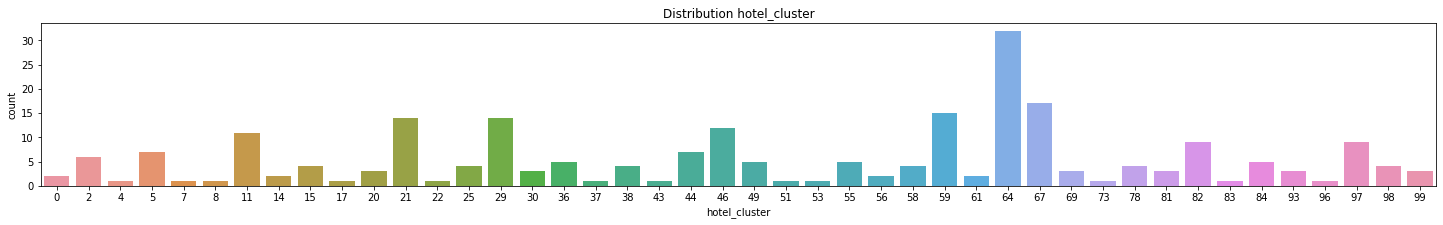

In [228]:
countplot(train[train['user_id'] == 527020], 'hotel_cluster')

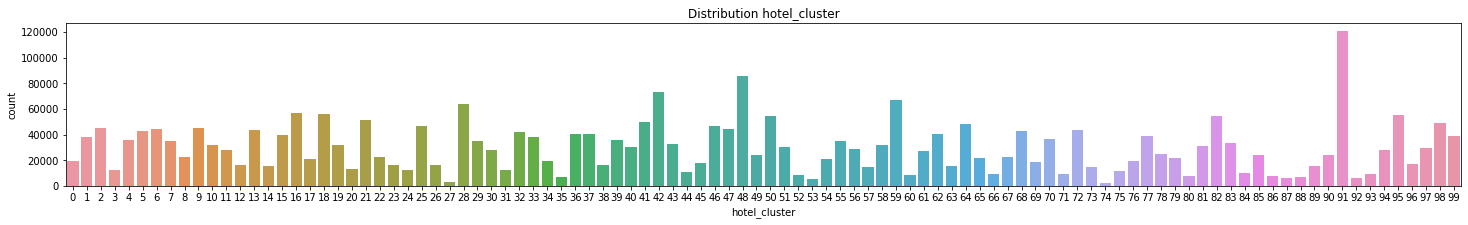

In [275]:
countplot(train_bookings, 'hotel_cluster')

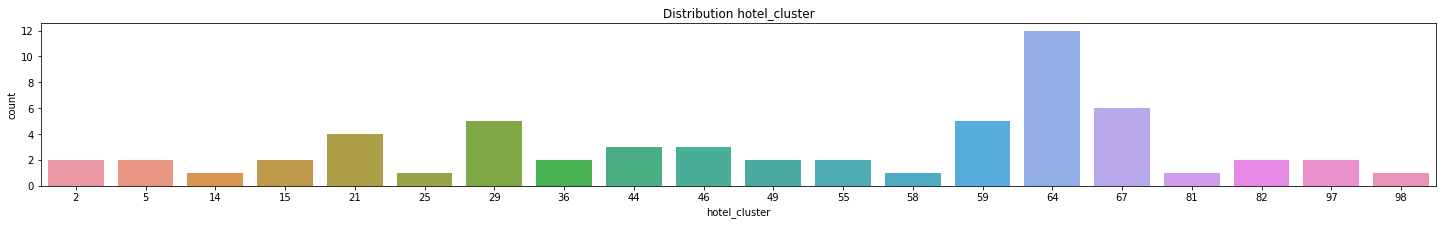

In [227]:
# Hotel cluster of one customer
countplot(train_bookings[train_bookings['user_id'] == 527020], 'hotel_cluster')

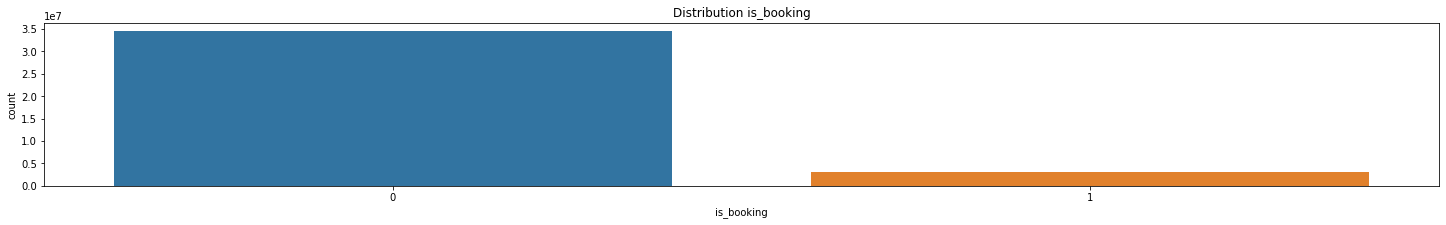

In [120]:
# Mucht more clicks than bookings in the training set. Are the clicks only in to extent the training data?
countplot(train, 'is_booking')

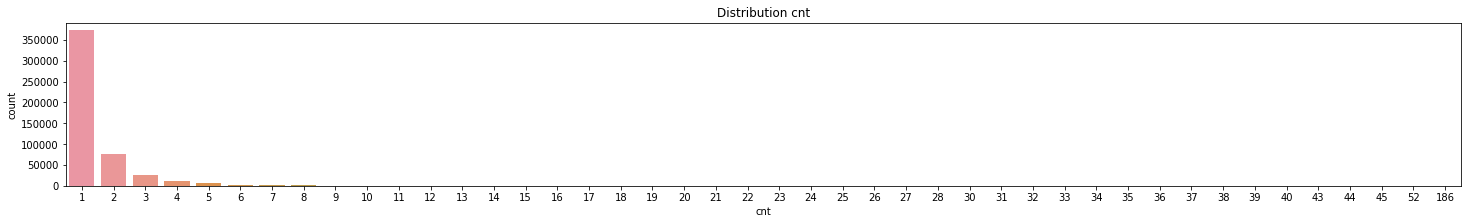

In [67]:
# Most user events only have a count of 1 of the similar events in the context of the same user session
countplot(train_sample, 'cnt')

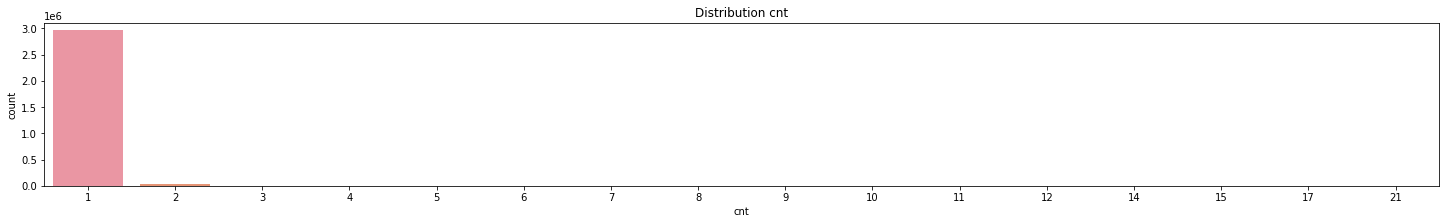

In [129]:
# And for the bookings only, the cnt is almost always 1.
countplot(train_bookings, 'cnt')

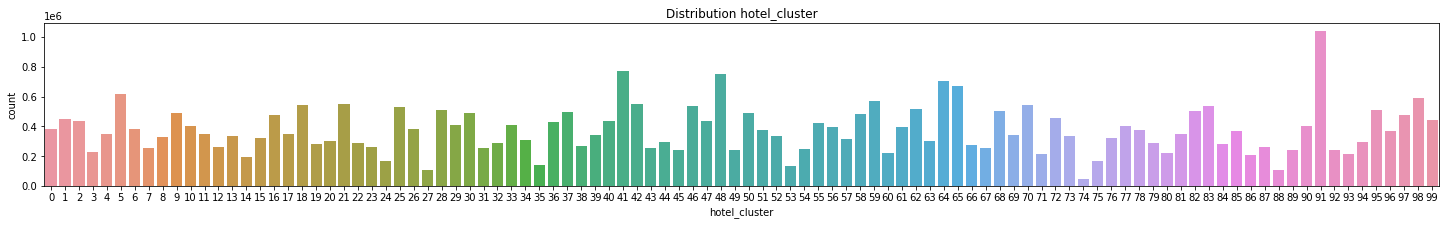

In [121]:
countplot(train, 'hotel_cluster')

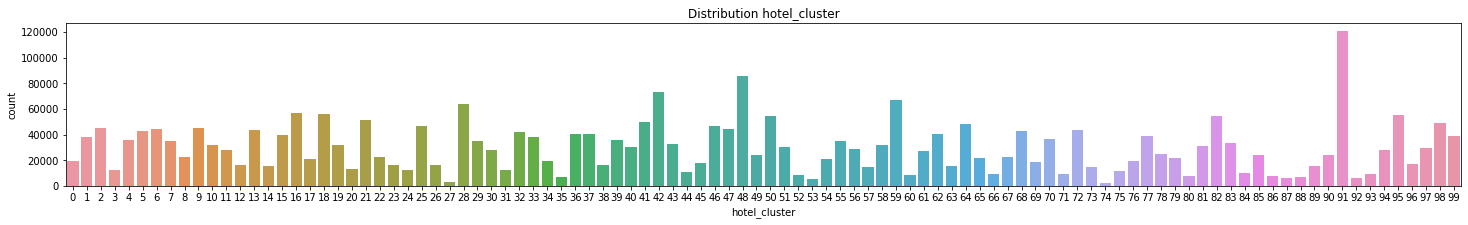

In [128]:
# Similar distribution for only bookings in the training set
countplot(train_bookings, 'hotel_cluster')

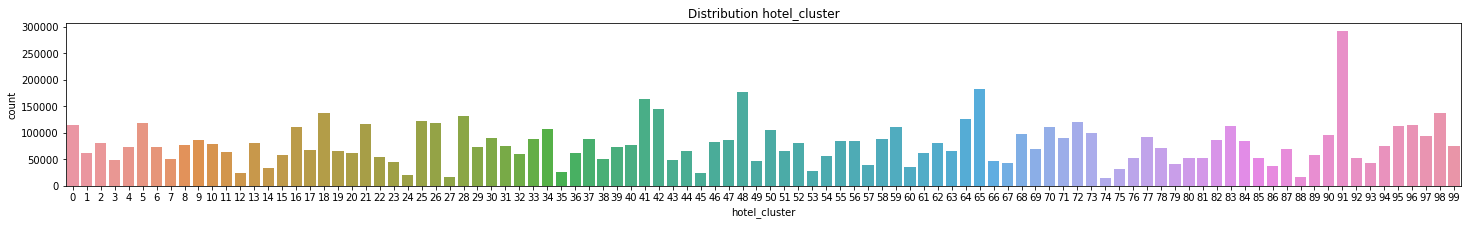

In [137]:
countplot(train[train['srch_children_cnt'] > 0], 'hotel_cluster')

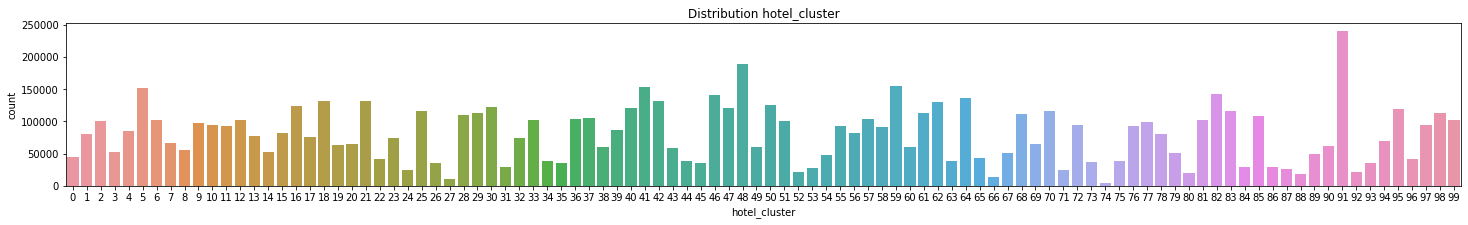

In [138]:
countplot(train[train['srch_adults_cnt'] == 1], 'hotel_cluster')

### Input features

In [171]:
# There are some null values
train.isna().sum()

date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47083
srch_co                         47084
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64

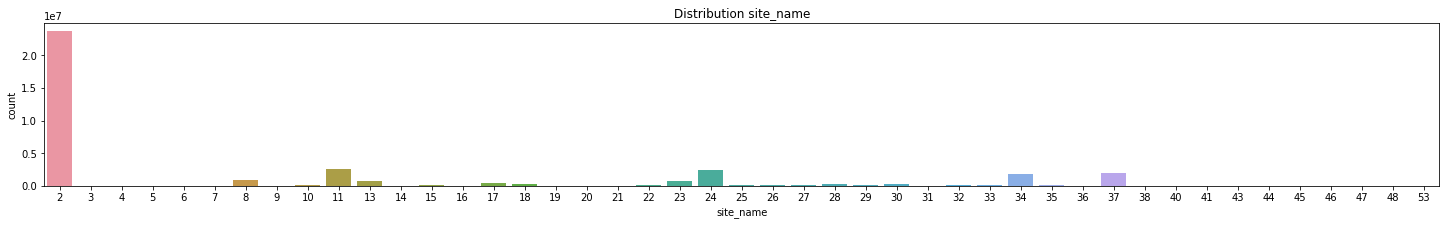

In [130]:
countplot(train, 'site_name')

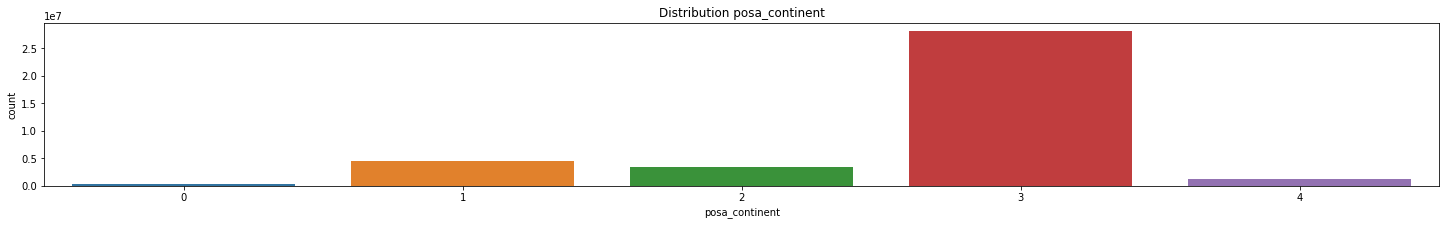

In [131]:
countplot(train, 'posa_continent')

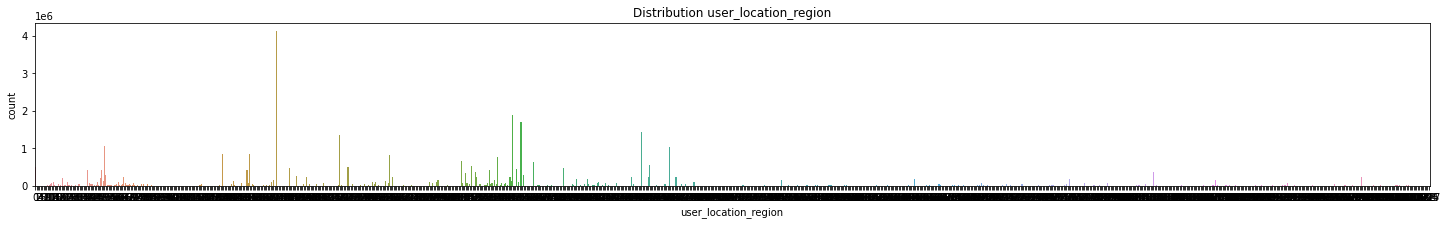

In [133]:
countplot(train, 'user_location_region')

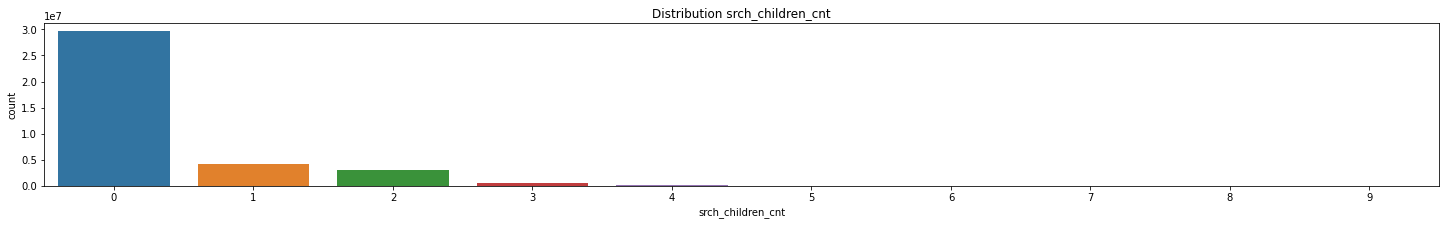

In [135]:
# Most common to not have any children
countplot(train, 'srch_children_cnt')

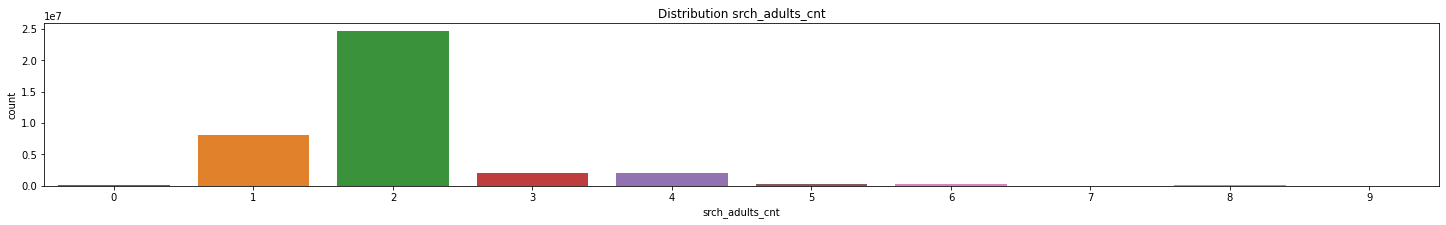

In [136]:
# Most bookings are for two adults
countplot(train, 'srch_adults_cnt')

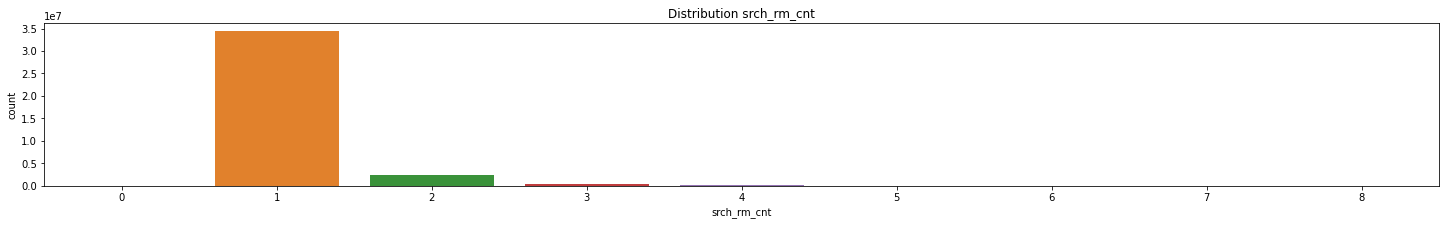

In [142]:
# Most look for one room appartments
countplot(train, 'srch_rm_cnt')

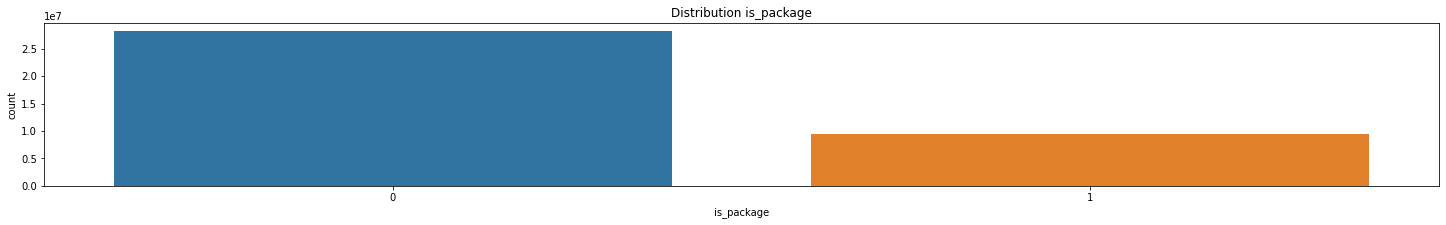

In [179]:
countplot(train, 'is_package')

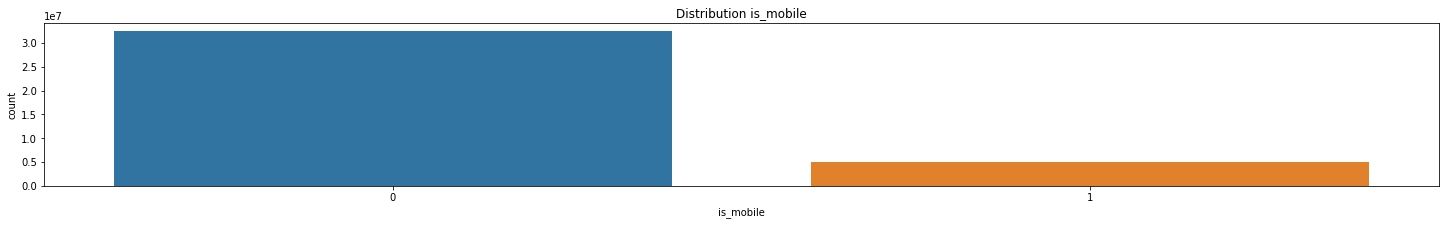

In [180]:
countplot(train, 'is_mobile')

In [178]:
[dt.datetime.strptime(x, '%Y-%m-%d') for x in train['srch_ci'].values if x]

TypeError: strptime() argument 1 must be str, not float

In [153]:
import datetime as dt

train['srch_ci_date'] = train['srch_ci'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

TypeError: strptime() argument 1 must be str, not float

## Test

* is_booking: 1 if a booking, 0 if a click	
* cnt: Numer of similar events in the context of the same user session
* hotel_cluster: ID of a hotel cluster

In [21]:
set(train.columns) - set(test.columns)

{'cnt', 'hotel_cluster', 'is_booking'}

In [134]:
test.columns

Index(['id', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'hotel_continent', 'hotel_country', 'hotel_market'],
      dtype='object')

In [201]:
print("Percentage existing users in test set: ")
len(set(train['user_id']) & set(test['user_id'])) / len(set(test['user_id'])) * 100

Percentage existing users in test set: 


100.0

In [23]:
test.shape

(2528243, 22)

In [22]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


## Sample submission

In [28]:
sample_submission.head()

,id,hotel_cluster
0,0,99 1
1,1,99 1
2,2,99 1
3,3,99 1
4,4,99 1


# Feature ideas:

* Searching on holidag param: When the distance is small and device is mobile - booking while being on a holiday
* When booking is part of a package meaning it includes a flight, the distance while booking will not be 0.
* History of the user; we need to make a prediction per user event, but we also have past records of the user.
* Create types of bookers: single, couple, couple with kids, large groups
* Number of days search for accomodation
* Weekend/week accomodation

## Model ideas:

Simple:
* Return the top 1, 2, 3, 4, 5 hotel cluster for each record 

Recommender:
* ALS
* Bandits

Classification:
* SVM
* Gradient Boosting

## Questions:
* What is the `cnt` parameter? I guess to reduce the number of records, meaning the same users clicked/booked cnt number of times the same accomodation.
* Should we take the `is_booking` = 0 into account as they are not part of the test set? Yes, it is extra information about the training set.
* For the training set, what is the correct cluster for the user event? The `hotel_market` parameter.

## Evaluation

https://www.kaggle.com/c/expedia-hotel-recommendations/overview/evaluation

Submissions are evaluated according to the Mean Average Precision @ 5 (MAP@5):



In [100]:
correct_clusters = np.ones(len(sample_submission)) * 99
correct_clusters

array([99., 99., 99., ..., 99., 99., 99.])

In [105]:
predicted_clusters = sample_submission['hotel_cluster'].apply(lambda x: [int(i) for i in x.split(' ')])

In [118]:
def get_mean_average_precision(predicted, correct):

    average_precision = []
    
    cutoff = 5
    
    for i, cluster in enumerate(correct):
        average_precision.append(int(cluster in predicted[i][:cutoff]) / len(predicted[i][:cutoff]))

    return np.mean(average_precision)

In [119]:
get_mean_average_precision(predicted_clusters, correct_clusters)

0.5

## (Pure) collaborative filtering

https://realpython.com/build-recommendation-engine-collaborative-filtering/

To build a system that can automatically recommend items to users based on the preferences of other users, the first step is to find similar users or items. The second step is to predict the ratings of the items that are not yet rated by a user. So, you will need the answers to these questions:

How do you determine which users or items are similar to one another?
Given that you know which users are similar, how do you determine the rating that a user would give to an item based on the ratings of similar users?
How do you measure the accuracy of the ratings you calculate?

In [261]:
# Start only with the bookings
user_bookings = (train_bookings[['user_id', 'hotel_cluster']]
                 .groupby('user_id')
                 .agg({'hotel_cluster': list})
                 .reset_index())
user_bookings

In [262]:
# Fill feedback matrix
feedback = np.zeros([n_users, n_clusters])
for user in user_bookings.index:
    feedback[user, user_bookings.loc[user, 'hotel_cluster']] = 1

In [274]:
from scipy import spatial

spatial.distance.cosine(feedback[0], feedback[4])

1.0

In [289]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.26410,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.26410,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.26410,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.19320,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.62590,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21
